In [1]:
import os
import nltk
import nltk.tokenize
import re
import unidecode
import collections
import numpy as np
import csv
import matplotlib.pyplot as plt


In [2]:
nltk.download('punkt', quiet=True)

True

In [3]:
n = 142 # Choose a number for a song to inspect.

In [4]:
def read_data(csvfile):
	# Result: list (= row) of lists, without header.
	data = []
	headers = True
	with open(csvfile) as stream:
		reader = csv.reader(stream, delimiter=',')
		for row in reader:
			if not headers:
				data.append(row)

			headers = False

	return data

In [5]:
liedjesData = np.array(read_data('../../data/liedjes/liedjes.csv')) # create np.array to be able to order lexicographically
liedjesData = liedjesData[liedjesData[:, 1].argsort()] # order lexicographically on identifier just like the textlist
print(liedjesData[n])

['' 'amsterdam1857-1-feestliederen1860-04' 'Opwekkingslied' 'Io Vivat'
 '1860' 'M. Smidt' 'amsterdam1857-1']


In [6]:
def getlistOfTexts(rootdir):
    # input: directory with (subdirectory with) TXT-files to be handled
	# output: list of files lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

liedjesList = getlistOfTexts('../../data/liedjes')

In [7]:
print(liedjesList[n])

../../data/liedjes/amsterdam1857-1-feestliederen1860/amsterdam1857-1-feestliederen1860-04.txt


In [8]:
def texts2list(listOfTexts):
	# input: list of files lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfTexts:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

liedjes = texts2list(liedjesList)

In [9]:
print(liedjes[n])

Opwekkingslied

Komt, Leden-rij,
Komt, vieren wij
Dit blijde Vriendenfeest.
't Herinnert ons den blijden dag,
Die Costers beeld onthullen zag.
Ja hem alleen,
En anders geen ,
Verheffen we in den geest.

Op elken stond,
Met hart en mond
Word’ hij op ’t hoogst geschat,
Spreidt Neerlands Pers den glans ten toon,
Van Costers kunst, zoo heerlijk schoon ,
Dat Costers stand
In Nederland
Dit schoon dan steeds bevatt’!

Wie, wuft en wreed ,
Het land vergeet,
Waar Costers wieg mogt staan ,
Zijn kunstgenooten acht gering,
Hij zij geen deel van onzen kring.
Zijn trotsch gevoel
Miskent het doel,
Waarvoor wij zijn ontstaan.

Geen flaauwe schijn
Van Lid te zijn
Van ons zoo schoon verbond,
Maar krachtig voort steeds, stap voor stap,
Dat voert ons tot den hoogsten trap:
Van Broedermin,
Vol hart en Zin ,
Tot eer van Costers vond.

Wat zinke of vall',
De Pers sta pal,
Tot nut van Costers stand,
Kweekt Liefde en Eendragt in de borst
Zij ’t hart dan met geen ijs omschorst ,
Neen, Costers eer
Zij onze leer,

In [10]:
def is_punctuation(string):
	# Result: A boolean for being a punctuation mark or not
	return re.compile(r'[^\w\s]+$').match(string) is not None

def remove_diacritics(string):
	# Result: A string without diacritics (accents)
	return unidecode.unidecode(string)

def preprocess_text(string):
	# Result: list of tokens in a string (= "tokenized corpus")
	string = string.lower()
	tokens = nltk.tokenize.word_tokenize(string, language="dutch")
	tokens = [token for token in tokens if not is_punctuation(token)]
	tokens = [remove_diacritics(token) for token in tokens]

	return tokens

tokenized_liedjes = [preprocess_text(liedje) for liedje in liedjes]

In [11]:
print(tokenized_liedjes[n])

['opwekkingslied', 'komt', 'leden-rij', 'komt', 'vieren', 'wij', 'dit', 'blijde', 'vriendenfeest', "'t", 'herinnert', 'ons', 'den', 'blijden', 'dag', 'die', 'costers', 'beeld', 'onthullen', 'zag', 'ja', 'hem', 'alleen', 'en', 'anders', 'geen', 'verheffen', 'we', 'in', 'den', 'geest', 'op', 'elken', 'stond', 'met', 'hart', 'en', 'mond', 'word', 'hij', 'op', 't', 'hoogst', 'geschat', 'spreidt', 'neerlands', 'pers', 'den', 'glans', 'ten', 'toon', 'van', 'costers', 'kunst', 'zoo', 'heerlijk', 'schoon', 'dat', 'costers', 'stand', 'in', 'nederland', 'dit', 'schoon', 'dan', 'steeds', 'bevatt', 'wie', 'wuft', 'en', 'wreed', 'het', 'land', 'vergeet', 'waar', 'costers', 'wieg', 'mogt', 'staan', 'zijn', 'kunstgenooten', 'acht', 'gering', 'hij', 'zij', 'geen', 'deel', 'van', 'onzen', 'kring', 'zijn', 'trotsch', 'gevoel', 'miskent', 'het', 'doel', 'waarvoor', 'wij', 'zijn', 'ontstaan', 'geen', 'flaauwe', 'schijn', 'van', 'lid', 'te', 'zijn', 'van', 'ons', 'zoo', 'schoon', 'verbond', 'maar', 'kracht

In [12]:
def extract_vocabulary(tokenized_corpus, min_count=1, max_count=float('inf')):
	# Result: list of unique words derived from a list of lists of strings
	vocabulary = collections.Counter()
	for document in tokenized_corpus:
		vocabulary.update(document)
	vocabulary = { 
		word for word, count in vocabulary.items()
		if count >= min_count and count <= max_count
	}

	return sorted(vocabulary)

liedjesVocabulary = extract_vocabulary(tokenized_liedjes, min_count=2)
# print(liedjesVocabulary)

In [13]:
def corpus2dtm(tokenized_corpus, vocabulary):
	# Result: Document Term Matrix: 
	# rows being documents in tokenized_corpus, columns being the words in vocabulary, 
	# values being the count of the word in the document
	document_term_matrix = []
	for document in tokenized_corpus:
		document_counts = collections.Counter(document)
		row = [document_counts[word] for word in vocabulary]
		document_term_matrix.append(row)

	return document_term_matrix

dtm_liedjes = np.array(corpus2dtm(tokenized_liedjes, liedjesVocabulary))

In [14]:
# print vector of song $n
for i in range(len(dtm_liedjes[n])):
    if dtm_liedjes[n][i] > 0:
        print(liedjesVocabulary[i],dtm_liedjes[n][i])

't 1
aan 1
aard 1
acht 1
afgedaald 1
alleen 1
als 1
anders 1
band 1
beeld 1
bemind 1
bereid 1
bestraald 1
bindt 1
blijde 1
blijden 1
blijv 2
blijven 1
bloei 1
bloeije 1
borst 1
broedermin 1
costers 9
dag 1
dan 6
dat 6
de 6
deel 1
deez 2
den 4
der 2
deugd 1
dezen 1
die 1
dit 3
doel 1
door 1
drukpers 3
eendragt 4
eenmaal 1
eer 2
elk 1
elken 1
en 11
er 1
feest 1
geen 4
geest 3
geschat 2
gevoel 1
glans 1
groot 1
haar 1
hart 5
heeft 1
heerlijk 1
heil 2
hem 1
hemel 1
herinnert 1
het 2
hij 2
hoogst 1
hoogsten 1
ijs 1
in 5
io 2
ja 1
keus 1
komt 2
kracht 2
krachtig 1
kring 1
kunst 2
kunstgenooten 1
kweekt 1
land 1
landgenoot 1
leer 1
leus 1
licht 2
lid 1
liefde 2
maakt 1
maar 1
magt 1
meerder 1
men 1
met 3
mogt 1
mond 1
naar 2
nederland 1
neem 1
neen 1
neerlands 2
niet 1
nooit 1
nut 2
of 2
ons 7
onthullen 1
ontstaan 1
onze 1
onzen 2
ook 1
op 4
oproer 1
oud-hollands 1
pal 1
pers 3
pligt 2
rij 1
schijn 1
schoon 4
schoone 1
smart 1
spreidt 1
spreuk 1
sta 1
staan 1
stand 3
stap 2
steeds 9
stond 1
s

In [15]:
document_distance_matrix = []
all_values = []
for i in range(len(liedjesList)):
    a = dtm_liedjes[i]
    row = []
    for j in range(len(liedjesList)):
        b = dtm_liedjes[j]
        cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        row.append(cos_sim)
        if cos_sim < 1:
            all_values.append(cos_sim)
    document_distance_matrix.append(row)


In [ ]:
document_topic_distance_matrix = []
all_values = []
for i in range(len(liedjesList)):
    a = dtm_liedjes[i]
    row = []
    for j in range(len(topicVectors)):
        b = topicVectors[j]
        cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        row.append(cos_sim)
        if cos_sim < 1:
            all_values.append(cos_sim)
    document_topic_distance_matrix.append(row)

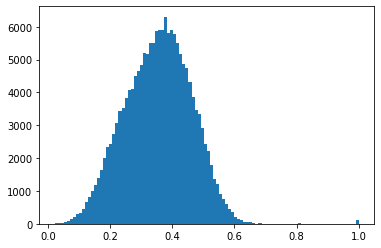

In [16]:
plt.hist(all_values, bins = 100)
plt.show()

In [17]:
for i in range(len(liedjesList)):
    for j in range(len(liedjesList)):
        if document_distance_matrix[i][j] > 0.9 and document_distance_matrix[i][j] < 0.99:
            print(document_distance_matrix[i][j])
            print(liedjesData[i])
            print(liedjesData[j])
            print("------------")


0.9645752461085684
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-07'
 'TOT COSTERS EER' 'Wien Neerlands bloed' '1856' 'J.P. Bladergroen'
 'rotterdam1849']
['https://zotero.org/groups/2707622/items/F6DWAKEH'
 'middelburg1847-feestbundel1864-30b' 'Slotzang' 'Wien Neerlands bloed'
 '1854' '' 'middelburg1847']
------------
0.9798918252387112
['https://zotero.org/groups/2707622/items/VL4IRLV2'
 'amsterdam1847-reglement1848-03' '' '' '1848' '' 'amsterdam1847']
['' 'haarlem1851-feestliederen1860-06' 'Vriendschap'
 'De vrolijke Visscher' '1860' 'W.' 'haarlem1851']
------------
0.9316934293416761
['' 'amsterdam1849-feestbundel1851-05' 'De Medailles'
 'Marchand de parapluies' '1851' '' 'amsterdam1849']
['' 'amsterdam1849-feestliederen1852-13'
 'Lied op het vereeren der medailles' 'Marchand de parapluies' '1852'
 'J. Buhling' 'amsterdam1849']
------------
0.9316934293416761
['' 'amsterdam1849-feestliederen1852-13'
 'Lied op het vereeren der medailles' 'Marchand de parapluies' '18

In [18]:
for i in range(len(liedjesList)):
    if document_distance_matrix[n][i] > 0.5:
        print(liedjesData[i])

['https://zotero.org/groups/2707622/items/I664294A' 'album1856-09'
 'HEIL DE KUNST' "Henri's drinklied" '1856' 'G. Nijman' 'denbosch1849']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-11'
 'BROEDERLIED VOOR TYPOGRAPHISCHE VEREENIGINGEN'
 'O groote koopman in tabak' '1856' 'M. Uitenbosch' 'haarlem1851']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-14'
 'COSTERS LOF' '' '1856' 'W.J. de Gruijter' 'denhaag1843']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-24'
 "DOOR EENDRAGT 'T ZAAM VERBONDEN" 'Wien Neerlands bloed' '1856' 'B. Kuit'
 'denhaag1843']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-35'
 'FEESTLIED' 'Wien Neerlands bloed' '1856' 'J.P. Nobels' 'haarlem1851']
['https://zotero.org/groups/2707622/items/I664294A' 'album1856-52'
 'DE UITVINDING DER BOEKDRUKKUNST. Cantate TE ZINGEN DOOR ALLE LEDEN DER TYPOGRAPHISCHE VEREENIGINGEN, BIJ HET STANDBEELD OF IN DEN HOUT, OP GEMAKKELIJKE EN MEEST BEKENDE ZANGWIJZEN.'
 '' 

In [19]:
# search for a term in the vocabulary
def find(searchterm):
    result = []
    i = 0
    term_index = -1

    for word in liedjesVocabulary:
        if liedjesVocabulary[i] == searchterm:
            term_index = i
        i = i + 1

    if term_index > -1:
        for j in range(len(liedjesList)):
            if dtm_liedjes[j][term_index] > 0:
                result.append(j)

    return result

In [20]:
print(find("magt"))

[8, 15, 17, 41, 52, 75, 129, 138, 142, 150, 182, 218, 286, 340, 350]
